In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_classification_report
    
print(tf.__version__)

1.13.1


In [73]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 20  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 20
    MAX_LEN = 75
    EMBEDDING = 32

In [69]:
data = pd.read_csv("./data/drug_bio_all.csv", encoding="utf8")
data = data.fillna(method="ffill")
print("Number of sentences: ", len(data.groupby(['Sentence #'])))
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)
print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  1778
Number of words in the dataset:  5838
Tags: ['B-FREQUENCY', 'I-DRUG', 'I-STRENGTH', 'O', 'I-ROUTE', 'B-FORM', 'B-DOSAGE', 'B-DRUG', 'B-STRENGTH', 'B-DURATION', 'I-DURATION', 'I-DOSAGE', 'B-ROUTE', 'I-FREQUENCY']
Number of Labels:  14
What the dataset looks like:


,Unnamed: 0,Sentence #,Word,POS,Tag
0,0,Sentence: 0,Slight,ADJ,O
1,1,Sentence: 0,wean,NOUN,O
2,2,Sentence: 0,of,ADP,O
3,3,Sentence: 0,Levo,PROPN,B-DRUG
4,4,Sentence: 0,.,PROPN,O
5,5,Sentence: 0,.,PROPN,O
6,6,Sentence: 0,tolerated,VERB,O
7,7,Sentence: 0,to,PART,O
8,8,Sentence: 0,maintain,VERB,O
9,9,Sentence: 0,Map,PROPN,O


In [90]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [94]:
getter = SentenceGetter(data)
sent = getter.get_next()
sentences = getter.sentences

In [95]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('Processed sample:', X[0][:5])
print('Processed labels:', y[0][:5])

Raw Sample:  Slight wean of Levo . . tolerated to maintain Map goal > = 50 . .
Raw Label:  O O O B-DRUG O O O O O O O O O O O O
Processed sample: [2281  816 2078 5049 2511]
Processed labels: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [58]:
# Define a simple sequential model
def create_model():
    # Model definition
    input = Input(shape=(MAX_LEN,))
    model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                      input_length=MAX_LEN, mask_zero=True)(input) 
    model = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.1))(model)  # variational biLSTM
    model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
    crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
    out = crf(model)  # output
    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
    
    return model

In [55]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

model.save_weights(checkpoint_path.format(epoch=0))

In [57]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, 
                    validation_data=(X_te, np.array(y_te)),
                    epochs=EPOCHS,validation_split=0.1, verbose=2)

Train on 1422 samples, validate on 356 samples
Epoch 1/20
 - 8s - loss: 11.0035 - crf_viterbi_accuracy: 0.6618 - val_loss: 10.9471 - val_crf_viterbi_accuracy: 0.8365
Epoch 2/20
 - 8s - loss: 10.3157 - crf_viterbi_accuracy: 0.8382 - val_loss: 10.7370 - val_crf_viterbi_accuracy: 0.8406
Epoch 3/20
 - 9s - loss: 10.1129 - crf_viterbi_accuracy: 0.8537 - val_loss: 10.5606 - val_crf_viterbi_accuracy: 0.8649
Epoch 4/20
 - 9s - loss: 9.9644 - crf_viterbi_accuracy: 0.8838 - val_loss: 10.4740 - val_crf_viterbi_accuracy: 0.8928
Epoch 5/20
 - 9s - loss: 9.8814 - crf_viterbi_accuracy: 0.9093 - val_loss: 10.4331 - val_crf_viterbi_accuracy: 0.9063
Epoch 6/20
 - 9s - loss: 9.8335 - crf_viterbi_accuracy: 0.9197 - val_loss: 10.4153 - val_crf_viterbi_accuracy: 0.9085
Epoch 7/20
 - 9s - loss: 9.7975 - crf_viterbi_accuracy: 0.9278 - val_loss: 10.3920 - val_crf_viterbi_accuracy: 0.9177
Epoch 8/20
 - 8s - loss: 9.7666 - crf_viterbi_accuracy: 0.9340 - val_loss: 10.3694 - val_crf_viterbi_accuracy: 0.9223
Epoch 

In [49]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag, digits=4)
print(report)

              precision    recall  f1-score   support

    B-DOSAGE     0.5676    0.6495    0.6058        97
      B-DRUG     0.8664    0.8770    0.8717       732
  B-DURATION     0.0000    0.0000    0.0000         3
      B-FORM     0.7000    0.1228    0.2090        57
 B-FREQUENCY     0.6420    0.4643    0.5389       112
     B-ROUTE     0.8023    0.8866    0.8423       238
  B-STRENGTH     0.7945    0.7117    0.7508       163
    I-DOSAGE     0.4800    0.4286    0.4528        28
      I-DRUG     0.1852    0.1042    0.1333        48
  I-DURATION     0.0000    0.0000    0.0000         2
 I-FREQUENCY     0.7308    0.3220    0.4471        59
     I-ROUTE     0.0000    0.0000    0.0000        16
  I-STRENGTH     0.9044    0.8775    0.8908       302
           O     0.9691    0.9826    0.9758      9566
         PAD     1.0000    1.0000    1.0000     15277

    accuracy                         0.9764     26700
   macro avg     0.5761    0.4951    0.5145     26700
weighted avg     0.9741   

/Users/tittaya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tittaya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tittaya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])


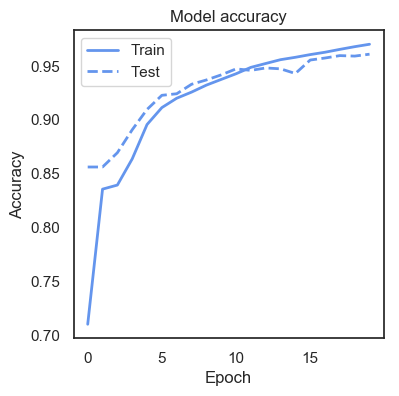

In [51]:
# list all data in history
print(history.history.keys())

# Set size and color for plots
sns.reset_defaults()
sns.set(rc={'figure.figsize':(4,4)},style="white")
color = 'cornflowerblue'
linestyles = ['-', '--', '-.', ':']

# summarize history for accuracy
plt.plot(history.history['crf_viterbi_accuracy'], linestyle=linestyles[0], color=color, linewidth=2)
plt.plot(history.history['val_crf_viterbi_accuracy'], linestyle=linestyles[1], color=color, linewidth=2)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.tight_layout()
plt.savefig('./figures/model_acc.png')
plt.show()

In [62]:
# Create a basic model instance
new_model = create_model()

# Evaluate the model
loss, acc = new_model.evaluate(X_te, np.array(y_te), verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

# Loads the weights
new_model.load_weights('./training/cp-0000.ckpt')

# Re-evaluate the model
loss,acc = model.evaluate(X_te, np.array(y_te), verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

/Users/tittaya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/tittaya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Untrained model, accuracy:  1.77%
Restored model, accuracy: 94.75%
